In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/work/S2/NLP/medal

Mounted at /content/drive
/content/drive/MyDrive/work/S2/NLP/medal


In [ ]:
%cd /content/drive/MyDrive/Dauphine/M2/S2/NLP/medal

/content/drive/.shortcut-targets-by-id/1dTU_fWmo-GgD0weht-axklYZOGKWSKf5/NLP/medal


In [ ]:
! pip install transformers
! pip install fasttext

     |████████████████████████████████| 4.0 MB 4.1 MB/s 
     |████████████████████████████████| 77 kB 8.8 MB/s 
     |████████████████████████████████| 596 kB 93.7 MB/s 
     |████████████████████████████████| 6.6 MB 45.0 MB/s 
     |████████████████████████████████| 895 kB 78.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 68 kB 3.3 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3147773 sha256=1e219bb824378be6280d0c1de10921041991738c007bc634568a316277bfbb80
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch import nn

import random
import pandas as pd
import numpy as np
import tensorflow as tf
import tqdm

from transformers import AutoModel, ElectraTokenizer
from downstream.utils import evaluate, load_mimic_mortality, load_model
from downstream.electra import Electra

from downstream.tokenizer_and_dataset import FastTextTokenizer, MimicDataset, HuggingfaceDataset

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%matplotlib inline
plt.style.use('seaborn')

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

base_model = AutoModel.from_pretrained("google/electra-small-discriminator")
finetuned_model = AutoModel.from_pretrained("xhlu/electra-medal")

print("Models loaded")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/618 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.5M [00:00<?, ?B/s]

Models loaded


In [ ]:
base_model.config

ElectraConfig {
  "_name_or_path": "google/electra-small-discriminator",
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
n_heads = base_model.config.num_attention_heads
n_layers = base_model.config.num_hidden_layers

In [ ]:
toy_data = pd.read_csv('/content/drive/MyDrive/Dauphine/M2/S2/NLP/medal/toy_data/sample.csv')

In [ ]:
data = pd.DataFrame()
data['LABEL'], data['TEXT'] = toy_data['LABEL'], toy_data['TEXT']

In [ ]:
data.sample(frac=1, random_state=32)

,LABEL,TEXT
201,operation,this study has investigated the relationship b...
44,arginine,primary amines react with pentanedione at ph t...
245,activities,the effect of feeding a relatively lowprotein ...
254,fatty acid synthetase,subcutaneous or intraabdominal injections of m...
14,alone,a doubleblind study with intraindividual compa...
...,...,...
71,onset,the action of snake venom phospholipases a in ...
252,liver,the system involved in the reduction of dibrom...
88,enriched,T3 a mus laser flash a mus phase in the decay ...
43,tyrosine,the properties of the functional groups in a p...


In [ ]:
data = data.to_numpy()

### Plot cosine similarity map

In [ ]:
all_similarities = []

for example in data:
    input = tokenizer(example[1], return_tensors='pt')
    
    input_ids, input_mask, token_type_ids = input['input_ids'], input['attention_mask'], input['token_type_ids']
    
    base_output = base_model(input_ids, input_mask, token_type_ids, output_attentions=True)
    finetuned_output = finetuned_model(input_ids, input_mask, token_type_ids, output_attentions=True)

    base_attentions = torch.stack(base_output.attentions, dim=1)
    finetuned_attentions = torch.stack(finetuned_output.attentions, dim=1)
    
    base_vec = base_attentions.squeeze(0).view(n_layers, n_heads, -1)
    finetuned_vec = finetuned_attentions.squeeze(0).view(n_layers, n_heads, -1)

    sim_map = torch.nn.functional.cosine_similarity(base_vec, finetuned_vec, dim=-1).detach().numpy()
    all_similarities.append(sim_map)

all_similarities = np.stack(all_similarities, axis=-1)
avg_sim = np.mean(all_similarities, axis=-1)

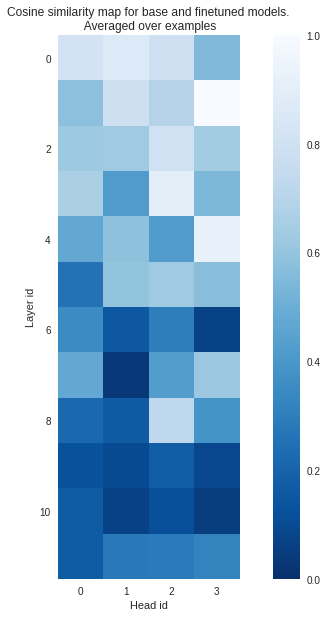

In [ ]:
plt.figure(figsize=(12, 10))
plt.imshow(avg_sim, cmap='Blues_r', vmin=0, vmax=1)
plt.colorbar()
plt.grid(False)
plt.title('Cosine similarity map for base and finetuned models.\n Averaged over examples')
plt.xlabel('Head id')
plt.ylabel('Layer id')

plt.show()

## Head pruning

In [ ]:
def random_head_pruning(n_layers=12, n_heads=4):
  # Dictionnary creation
  dico = {}
  for i in range(n_layers):
    dico[i] = []
  
  # Random nb of layers to modify
  n_layers_to_prune = np.random.randint(0,n_layers//2-1)
  for i in range(n_layers_to_prune):
    # Random selection of the id of layers to be modified
    pruned_layers = np.random.choice(n_layers, n_layers_to_prune, replace=False)
    
    for layer in pruned_layers:
      # Random nb of heads to prune
      n_heads_to_prune = np.random.randint(0, n_heads)
      # Random selection of the id of the head to be pruned
      pruned_heads = np.random.choice(n_heads, n_heads_to_prune, replace=False)

      # Dictionnary modification
      dico[layer] = pruned_heads.tolist()
    
  return dico

In [ ]:
heads_to_prune = random_head_pruning(12,4)
heads_to_prune

{0: [],
 1: [],
 2: [],
 3: [],
 4: [0, 1, 2],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: []}

In [ ]:
model_ckpt = "models/electra_base_mortality_3.pt"

In [ ]:
n_eval = 50

# Load data
train, valid, test = load_mimic_mortality("./data/downstream", "mimic.csv")
print("Data loaded")

# Create tokenizer objects
tokenizer = ElectraTokenizer.from_pretrained('google/electra-small-discriminator')

output_size = 1
label_col = 'LABEL_NUM'
TASK = "mimic-mortality"

torch.set_num_threads(4)
DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

# Create torch Dataset objects
test_data = HuggingfaceDataset(test, tokenizer=tokenizer, task=TASK, label_col=label_col, output_size=output_size, device=DEVICE)
print("Data created")

sample_map = random.sample(range(len(test)),int(len(test)/4)) # could be the size of sample
test_loader = DataLoader(sample_map, shuffle=False, batch_size=8)

Data loaded
Data created


In [ ]:
def test_models_on_subsample(test_loader, test_data, model_ckpt=None, heads_to_prune={}):
  DEVICE = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")

  # Define networks, loss function and optimizer
  net = Electra(output_size=output_size, device=DEVICE)
  net = load_model(net, model_ckpt, DEVICE)

  pruned_net = Electra(output_size=output_size, device=DEVICE)
  pruned_net = load_model(pruned_net, model_ckpt, DEVICE)
  pruned_net.electra.prune_heads(heads_to_prune)

  print("Models created")

  # Test
  logs = {k: [] for k in ['test_loss', 'test_metric','test_pruned_loss','test_pruned_metric']}
  criterion = nn.BCELoss()

  test_loss, test_metric = evaluate(net, test_loader, test_data, criterion, verbose=True, task=TASK)
  test_pruned_loss, test_pruned_metric = evaluate(pruned_net, test_loader, test_data, criterion, verbose=True, task=TASK)

  logs['test_loss'].append(test_loss)
  logs['test_metric'].append(test_metric)

  logs['test_pruned_loss'].append(test_pruned_loss)
  logs['test_pruned_metric'].append(test_pruned_metric)

  print(logs)

  return logs

In [ ]:
df = pd.DataFrame(index=range(n_eval), columns=['test_loss', 'test_metric', 'test_pruned_loss', 'test_pruned_metric'])

for i in range(n_eval):
  heads_to_prune = random_head_pruning()
  print(heads_to_prune)
  logs = test_models_on_subsample(test_loader, test_data, model_ckpt, heads_to_prune)
  df.loc[i,'test_loss'] = logs.get('test_loss')[0]
  df.loc[i,'test_metric'] = logs.get('test_metric')[0]
  df.loc[i,'test_pruned_loss'] = logs.get('test_pruned_loss')[0]
  df.loc[i,'test_pruned_metric'] = logs.get('test_pruned_metric')[0]

df

In [ ]:
df_base_test = df
df_base_test.mean(axis=0)